In [167]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import itertools
from tqdm import tqdm
import skimage.io as io
import plotly.express as px

In [2]:
def extract_variables(df, covariates, response):
    # Extract covariates
    X = df[covariates].values
    
    # Extract response variables
    y = df[response].values
    
    return X, y

In [67]:
covariates = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
response = ["ph"]

# define parameter grid
param_grid = {
    'max_depth': [100,200],
    'learning_rate': [0.3, 0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200]
}


# Read data

In [3]:
data = pd.read_csv("../data/data_match_250.csv",index_col=0)

In [160]:
im = io.imread('../data/s2sr_250mpp.tif')

In [4]:
data.head()

,longitude,latitude,start_date,end_date,source,horizon_lower,horizon_upper,aluminium_extractable,boron_extractable,calcium_extractable,...,13,14,15,16,17,18,19,20,21,22
0,34.53812,-3.90260,01/01/2008,31/12/2018,afsis_spectral https://www.isda-africa.com/pos...,50,20,516.698,NaN,11031.132,...,0.228296,0.000498,0.016809,0.014120,0.011000,0.000002,0.0,0.0,0.0,0.0
1,34.51292,-3.87805,01/01/2008,31/12/2018,afsis_spectral https://www.isda-africa.com/pos...,50,20,540.774,NaN,10867.265,...,0.227836,0.000500,0.022167,0.018829,0.014704,0.000067,0.0,0.0,0.0,0.0
2,34.53746,-3.87215,01/01/2008,31/12/2018,afsis_spectral https://www.isda-africa.com/pos...,50,20,508.253,NaN,9819.300,...,0.231178,0.000502,0.021104,0.017936,0.013822,0.000002,0.0,0.0,0.0,0.0
3,34.53287,-3.82425,01/01/2008,31/12/2018,afsis_spectral https://www.isda-africa.com/pos...,50,20,428.065,NaN,970.240,...,0.226327,0.000493,0.014824,0.012524,0.009187,0.000000,0.0,0.0,0.0,0.0
4,34.53783,-3.54328,01/01/2008,31/12/2018,afsis_spectral https://www.isda-africa.com/pos...,50,20,693.100,NaN,3747.304,...,0.208100,0.000487,0.014257,0.010283,0.006843,0.000000,0.0,0.0,0.0,0.0


In [4]:
data.columns

Index(['longitude', 'latitude', 'start_date', 'end_date', 'source',
       'horizon_lower', 'horizon_upper', 'aluminium_extractable',
       'boron_extractable', 'calcium_extractable', 'carbon_organic',
       'carbon_total', 'copper_extractable', 'electrical_conductivity',
       'iron_extractable', 'magnesium_extractable', 'manganese_extractable',
       'nitrogen_total', 'ph', 'phosphorus_extractable',
       'potassium_extractable', 'sodium_extractable', 'sulphur_extractable',
       'zinc_extractable', 'lons_250m', 'lats_250m', 'geometry', '0', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15',
       '16', '17', '18', '19', '20', '21', '22'],
      dtype='object')

# Data exploration 

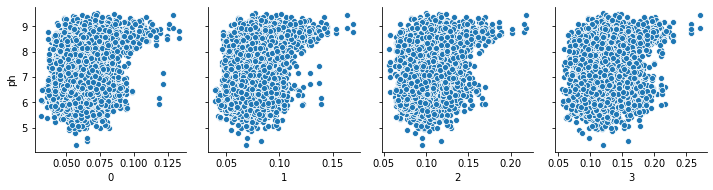

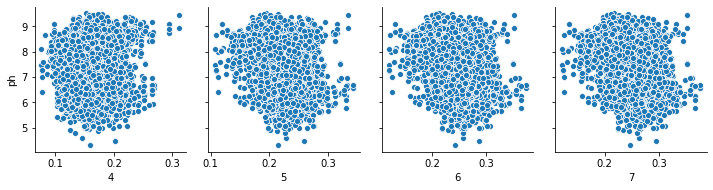

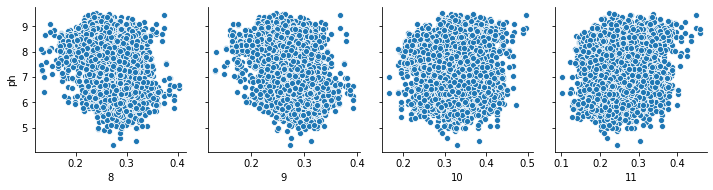

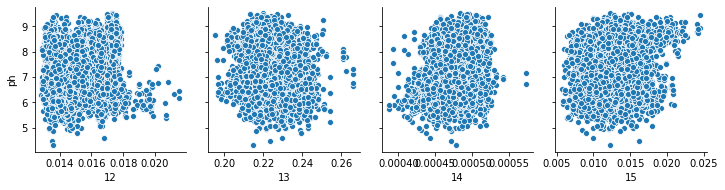

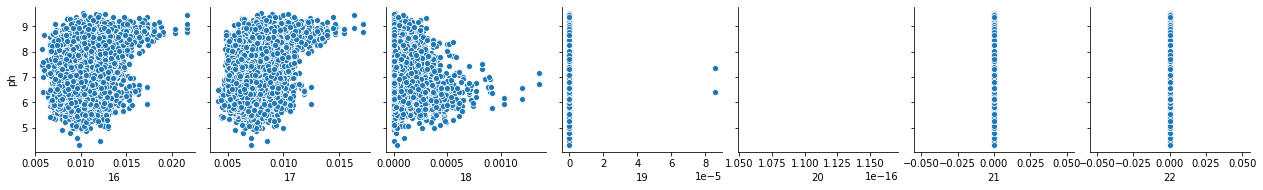

In [149]:
data_subset = data[['ph','0', '1', '2','3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15','16', '17', '18', '19', '20', '21', '22']]

# Define number of plots and variables per plot
vars_to_plot = ['0', '1', '2','3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15','16', '17', '18', '19', '20', '21', '22']
n_plots = 5
vars_per_plot = len(vars_to_plot) // n_plots

# Create multiple pairplots
for i in range(n_plots):
    start_index = i * vars_per_plot
    end_index = (i + 1) * vars_per_plot if i < n_plots - 1 else len(vars_to_plot)
    plot_vars = vars_to_plot[start_index:end_index]
    plot_df = data_subset[plot_vars + ['ph']]
    sns.pairplot(plot_df, y_vars='ph', x_vars=plot_vars, diag_kind='kde')

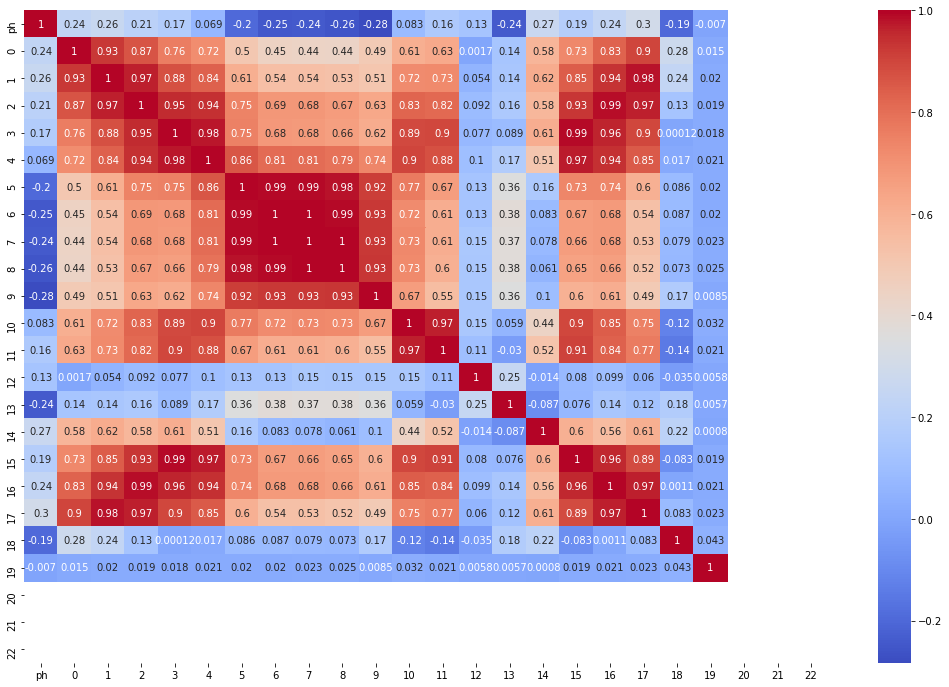

In [157]:
fig, ax = plt.subplots(figsize=(18,12))
# plot the correlation matrix using a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, annot_kws={"size": 10})

# Extract the relevant variables from the data

In [31]:
X, y = extract_variables(data,covariates,response)
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

(4938, 23)
(4938, 1)


# Modelling

In [96]:
# # Define model
# xgb_model = xgb.XGBRegressor(seed = 20) 
# xgb_model.fit(X_train, y_train)

# # Cross validataion 
# scores = cross_val_score(xgb_model, X_train, y_train, cv=5)
# print("Mean cross-validation score: %.2f" % scores.mean())

# kfold = KFold(n_splits=10, shuffle=True)
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

# y_pred = xgb_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print("MSE: %.2f" % mse)
# print("RMSE: %.2f" % (mse**(1/2.0)))

## Method 1 - GridSearchCV

In [69]:
# Define model
xgb_model = xgb.XGBRegressor(seed = 20) 

# Perform grid search to find best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=10)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Lowest RMSE: ", (grid_search.best_score_)**(1/2.0))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:   48.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   49.0s finished


Best parameters: {'learning_rate': 0.1, 'max_depth': 100, 'n_estimators': 50}
Lowest RMSE:  0.805945707230651


## Method 2 - Looping

In [58]:
# create XGBoost DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# create combinations of hyperparameters
combinations = list(itertools.product(*param_grid.values()))

# initialize progress bar
pbar = tqdm(total=len(param_grid))

# initialize best score and best parameters
best_score = float('inf')
best_params = None

# loop over all parameter combinations
for combination in combinations:
    # create dictionary of hyperparameters
    params = {
        'max_depth': combination[0],
        'learning_rate': combination[1],
        'n_estimators': combination[2],
        'objective': 'reg:squarederror'
    }
    
    # update progress bar
    pbar.set_description(f'Training {params}')    
    pbar.update(1)
    
    # train XGBoost model with current parameters
    model = xgb.train(params,dtrain)
    
    # evaluate model on validation set
    y_pred = model.predict(dtest)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # update best score and best parameters
    if score < best_score:
        best_score = score
        best_params = params
    
# close progress bar
pbar.close()

# print best score and best parameters
print(f'Best score: {best_score}')
print(f'Best parameters: {best_params}')



  0%|          | 0/3 [00:00<?, ?it/s]
Training {'max_depth': 100, 'learning_rate': 0.3, 'n_estimators': 50, 'objective': 'reg:squarederror'}:   0%|          | 0/3 [00:00<?, ?it/s]
Training {'max_depth': 100, 'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'reg:squarederror'}:  33%|███▎      | 1/3 [00:00<00:00, 10.72it/s]
Training {'max_depth': 100, 'learning_rate': 0.3, 'n_estimators': 200, 'objective': 'reg:squarederror'}:  67%|██████▋   | 2/3 [00:00<00:00, 12.47it/s]
Training {'max_depth': 100, 'learning_rate': 0.3, 'n_estimators': 200, 'objective': 'reg:squarederror'}: 100%|██████████| 3/3 [00:00<00:00, 18.26it/s]
Training {'max_depth': 100, 'learning_rate': 0.3, 'n_estimators': 1000, 'objective': 'reg:squarederror'}: 100%|██████████| 3/3 [00:00<00:00, 18.26it/s]
Training {'max_depth': 100, 'learning_rate': 0.1, 'n_estimators': 50, 'objective': 'reg:squarederror'}: : 4it [00:00, 18.26it/s]                       
Training {'max_depth': 100, 'learning_rate': 0.1, 'n_estimator

Best score: 0.630866559316769
Best parameters: {'max_depth': 100, 'learning_rate': 0.3, 'n_estimators': 50, 'objective': 'reg:squarederror'}


## Choose the best params to train again

In [113]:
params = best_params
# params = grid_search.best_params_
params

{'max_depth': 100,
 'learning_rate': 0.3,
 'n_estimators': 50,
 'objective': 'reg:squarederror'}

In [99]:
# define the final model
xgb_model = xgb.train(params,dtrain)
y_pred = xgb_model.predict(dtrain)
score = np.sqrt(mean_squared_error(y_train, y_pred))
print("Training score: ", score)
y_pred = xgb_model.predict(dtest)
score = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test score: ", score)

Training score:  0.3550946029687977
Test score:  0.630866559316769


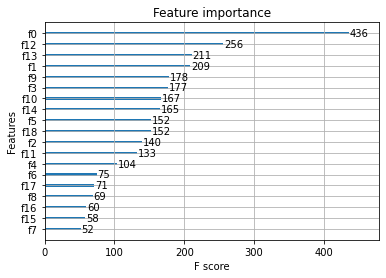

In [97]:
plot_importance(xgb_model)

## Choose the more important features to train again

In [109]:
covariates_final = ['0', '12', '13', '1', '9','3', '4']
X, y = extract_variables(data,covariates_final,response)
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

(4938, 7)
(4938, 1)


In [117]:
xgb_model = xgb.XGBRegressor(**params)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_train)
score = np.sqrt(mean_squared_error(y_train, y_pred))
print("Training score: ", score)
y_pred = xgb_model.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test score: ", score)

Training score:  0.20215381253935003
Test score:  0.5804602373731697


In [162]:
im_selected = im[:,:,(0, 12, 13, 1, 9, 3, 4)]
#0 - Ultra Blue (Coastal and Aerosol)
#1- Blue
#3 - Red
#9 - Short Wave Infrared (SWIR)
#12 -Aerosol Optical Thickness
#13 - Water Vapor Pressure

print(im_selected.shape)

preds = []
for i in im_selected:
    preds.append(xgb_model.predict(i))

(673, 1275, 7)

In [170]:
y_pred = xgb_model.predict(X)
score = np.sqrt(mean_squared_error(y, y_pred))
print("Training score: ", score)

Training score:  0.3601701197067692


In [172]:
len(X)

4938

In [173]:
data["y_pred"] = y_pred

# Visualisation

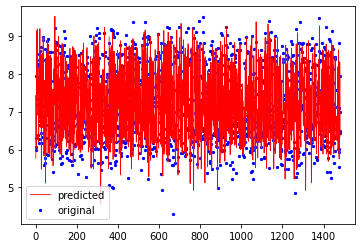

In [118]:
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

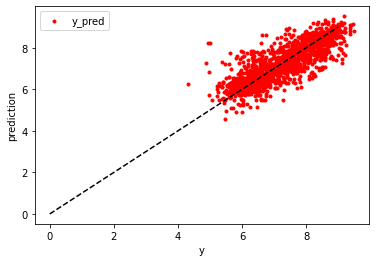

In [119]:
plt.scatter(y_test, y_pred, color='red', marker='.', label='y_pred')
plt.plot([0, 9], [0, 9], color='black', linestyle='--')
plt.xlabel('y')
plt.ylabel('prediction')
plt.legend()

plt.show()

(array([  4.,  25., 112., 339., 240., 222., 192., 179., 146.,  23.]),
 array([4.569573 , 5.064066 , 5.5585594, 6.053053 , 6.547546 , 7.042039 ,
        7.5365324, 8.031026 , 8.525518 , 9.020012 , 9.514505 ],
       dtype=float32),
 <a list of 10 Patch objects>)

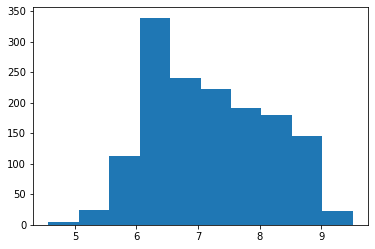

In [120]:
plt.hist(y_pred)

(array([  1.,  13.,  95., 266., 308., 201., 184., 200., 169.,  45.]),
 array([4.303 , 4.8224, 5.3418, 5.8612, 6.3806, 6.9   , 7.4194, 7.9388,
        8.4582, 8.9776, 9.497 ]),
 <a list of 10 Patch objects>)

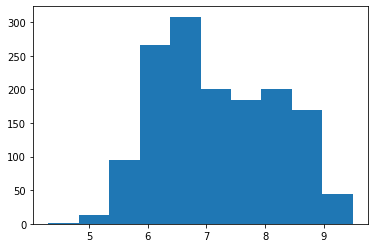

In [88]:
plt.hist(y_test)

In [179]:
# Set up mapbox access token
mapbox_access_token = 'pk.eyJ1IjoibWljYXRlbyIsImEiOiJjbGduZjJzeWwwN2ViM2Rwb3JyYnYyYXcxIn0.tsM4wDfrZjYa5ds4s9atSQ'

# Create a scatter map with tooltips
fig = px.scatter_mapbox(data, lat='latitude', lon='longitude', color='y_pred', hover_data=['ph'],
                        zoom=8, center={'lat': data['latitude'].mean(), 'lon': data['longitude'].mean()})

# Set up mapbox style and access token
fig.update_layout(mapbox_style='open-street-map', mapbox_accesstoken=mapbox_access_token)

# Show the map
fig.show()
